# Plot Y-Data Distribution
월리가 없는 이미지가 너무 많기 때문에 편향되어있다.
클래스 가중치를 주고 비율을 맞춰준다.

https://keras.io/models/sequential/

88666846 37154


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


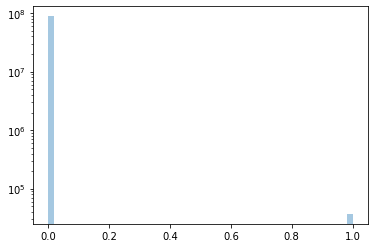

In [ ]:
#월리가 있는 곳은 1, 없는 곳은 0
freq0 = np.sum(labels==0)       # labels==0 (True) 일때 합계 (88666846개)
freq1 = np.sum(labels==1)       # labels==1 (False) 일때 합계 (37154개)

print(freq0, freq1)

sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})  
plt.show()

distplot() : 전체 라벨을 1차원으로 만들어준다.
 - kde : 밀집도 그래프
 - hist_kws : dict()형 매개변수로 그래프를 꾸미기

# Make Class Weights (0 and 1)

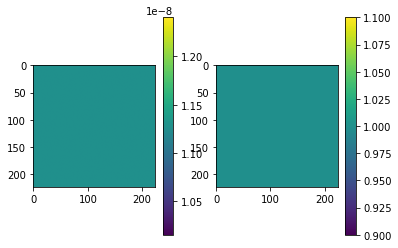

In [ ]:
sample_weights = np.zeros((6, PANNEL_SIZE * PANNEL_SIZE, 2))

# sample_weights의 모든 층의 모든 행의 0번 열[:,:,0], 1번 열[:,:,1]
sample_weights[:,:,0] = 1. / freq0                      # '1' 을 '월리가 없는 곳의 합계'로 나눠서 colorbar의 범위를 늘려준다.
sample_weights[:,:,1] = 1.

plt.subplot(1,2,1)                                      # 1x2(행x열)의 subplot에서 첫번째 subplot
plt.imshow(sample_weights[0,:,0].reshape((224, 224)))   # 0번층의 모든행의 0번 열
plt.colorbar()

plt.subplot(1,2,2)                                      # 1x2(행x열)의 subplot에서 두번째 subplot
plt.imshow(sample_weights[0,:,1].reshape((224, 224)))   # 0번층의 모든행의 1번 열

월리가 있는 부분과 없는 부분의 차이를 보정하기 위해 가중치(weight)를 주었다.   

class weight : 클래스 불균형을 해결하기 위한 방법
 - 샘플 수가 상대적으로 적은 Class 쪽에 가중치를 부여하는 방식이다.
 - 클래스 별 가중치 값을 dictionary 형태로 저장해서 넘겨준다.

# Train
 구축한 모델을 바탕으로 학습 시키기.


In [ ]:
# 위에서 만든 seg_gen_mix() 함수를 사용하여 각 배치마다 이미지들의 비율을 맞춰주고, 패널사이즈를 225x225로 통일시켜준다. 
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=6, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

# 각 epoch가 끝날 때마다 돌아갈 함수
def on_epoch_end(epoch, logs):
    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'], logs['acc']), end='')

# 각 에포크가 끝날 때 위에서 정의한 기능(on_epoch_end 함수)이 돌아가도록 한다.
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# 모델학습 시킨 것을 history에 넣어준다.
history = model.fit_generator(
    gen_mix, steps_per_epoch=6, epochs=500,
    class_weight=sample_weights,
    verbose=0,          
    callbacks=[
        print_callback,                           
        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, verbose=1, mode='auto', min_lr=1e-05)
    ]
)
                         

# save() : ‘모델 아키텍처’, ‘모델 가중치’를 ‘h5’파일 형식으로 모두 저장한다.
model.save('model.h5')

# 그래프 그리기
plt.figure(figsize=(12, 4))         # 그림판 크기
plt.subplot(1, 2, 1)                # # 1x2(행x열)의 subplot에서 첫번째 subplot
plt.title('loss')                   # loss 값
plt.plot(history.history['loss'])   # loss 값 그리기
plt.subplot(1, 2, 2)                # 1x2(행x열)의 subplot에서 두번째 subplot
plt.title('accuracy')               # accuracy 값
plt.plot(history.history['acc'])    # accuracy 값 그리기

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


ValueError: ignored

1. on_epoch_end() : 각 epoch가 끝날 때마다 돌아갈 함수   
      
       각 epoch마다 아래의 값들이 들어있다.
       - loss(훈련 손실값)
       - acc(훈련 정확도)
       - val_loss(검증 손실값)
       - val_acc(검증 정확도)   


2. LamdaCallback : 간단한 커스텀 콜백을 on-the-fly로 생성할 수 있는 콜백
- Callback : 모델 학습 중 호출할 수 있는 기능 의미
- 콜백을 사용해서 학습 중인 모델의 내부 상태와 통계값 확인


3. 1. fit_generator() : 이미지를 담고 있는 배치로 학습을 시키기 때문에 fit_generator()를 사용   

          gen_mix : 학습시킬 데이터
          steps_per_epoch=6 : 한 ephch당 스텝 6번
          epochs=500 : 총 500 epoch 
          class_weight=sample_weights : 샘플 수가 상대적으로 적은 Class 쪽에 가중치 부여 
          verbose=0 : 훈련과정 생략, 1 (default) : 훈련과정 출력 등        
          callbacks[] : 콜백의 리스트를 전달한다.
  
  2. ReduceLROnPlateau() : 모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도하는 콜백함수
          monitor : loss가 더이상 감소되지 않을 경우 적용,  
          factor :Learning rate 0.2씩 감소 (새로운 Learning rate = learning rate * factor)
          10번 training을 했는데도 연속해서 더이상 monitor되는 값의 개선이 없을 경우, ReduceLROnPlateau 콜백함수 실행
          verbose = 0 : 종료, 1 : EarlyStopping이 적용될 때 화면에 적용되었다고 나타남.
          mode : monitor되는 값. 모델이 자동으로 판단하도록 설정.
          min_lr : Learning rate의 하한선 지정. Learning rate가 1e-05보다 작은 값이 나와도 전부 1e-05 적용



### ※ .fit_generator의 class_weight 부분 문제 발견
 원본 코드는 그 당시 원활하게 진행되어 보였으나 현재는 오류가 나서 이 부분부터 진행이 원활하지 않았다. 그래서 우리는 오류가 나는 이유에 대해 찾아보았다.
하지만 자료가 많이 없었었다. 심지어 .fit_generator() 메소드는 Keras에서 곧 사라질 메소드라고 한다.   

 우리는 .fit()으로 메소드를 변경하여 프로젝트를 진행해야하나 고민을 했지만 여기에서 또 하나의 의문점이 들었다. '월리가가 있다, 없다 로 나뉘는데 왜 Binary cross entropy를 사용하는 이진분류 문제로 풀어낸 것이 아닌 .fit_generator() 메서드를 사용하여 class weight으로 접근 했을까?' 이 부분에 대해선 선생님께 여쭤보았다.   
 
 선생님께선 '이 코드는 단순히 월리가 있다, 없다가 아닌 다양한 캐릭터들을 분류하여 월리의 확률이 높은 캐릭터를 찾아내는 방식으로 접근한 것으로 보인다'라고 말씀해주셨다. 이 경우는 soft max를 사용해도 가중치로 충분히 분류가 가능하기 때문이다.








### ※ 문제에 대한 결론
'월리를 찾아라'의 주제는 CNN을 이용한 접근보다는 'Tensorflow Object Detection API'를 사용하는 접근이 더 적당해 보인다.   
1. 더 직관적인 소스코드로 작성이 가능하다.
2. Keras의 패키지들이 하나 둘 막히는 이유가 있을 것이라고 생각된다. 문서화가 잘 되어있는 Tensorflow를 사용하도록 하자.